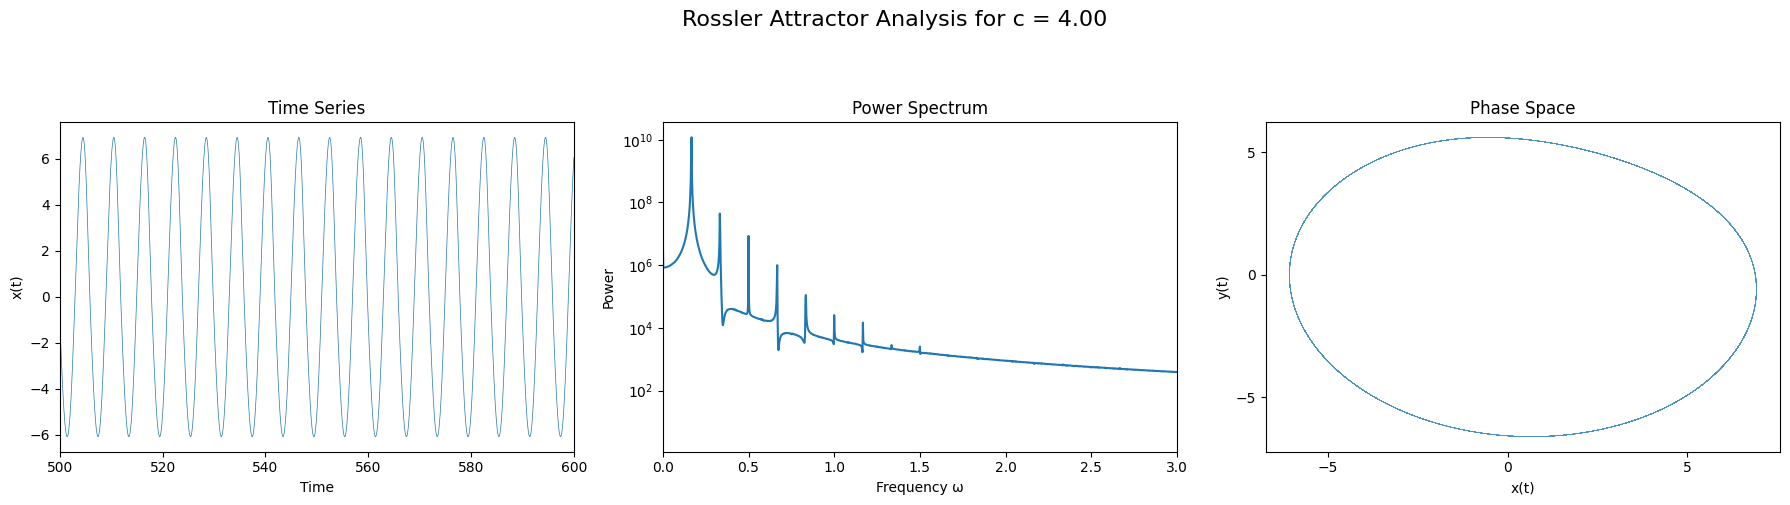

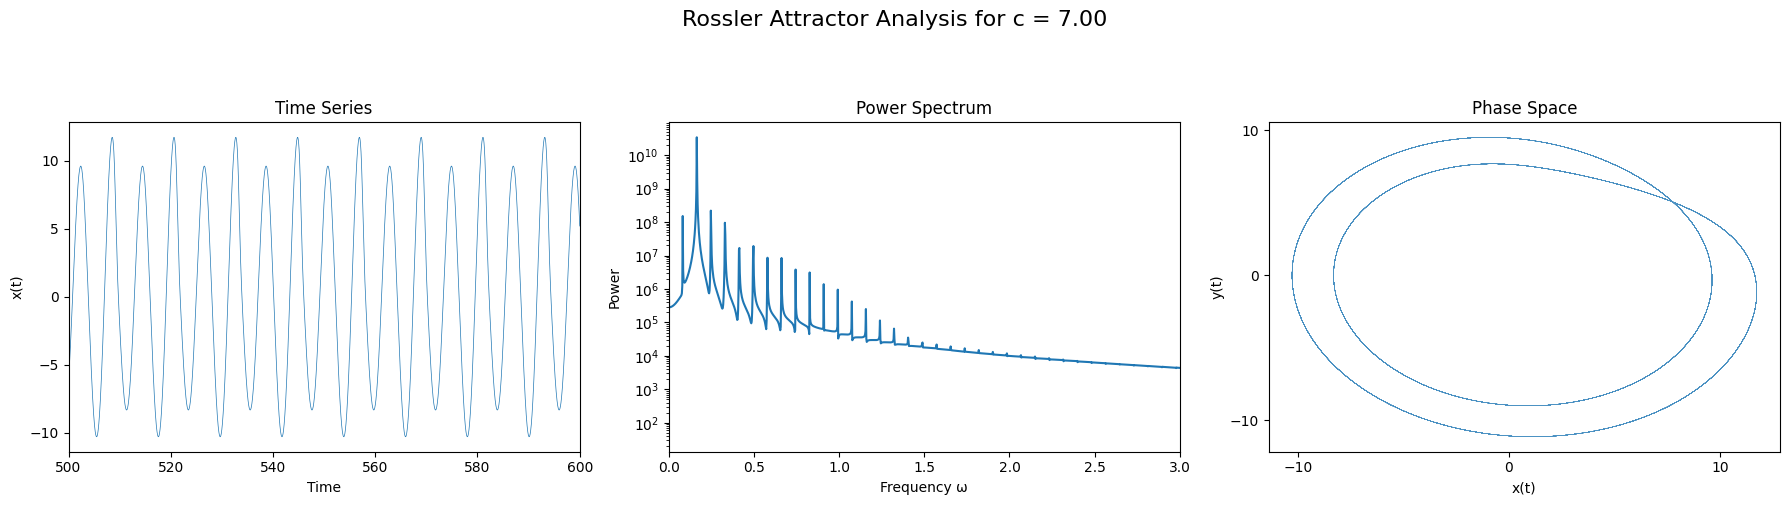

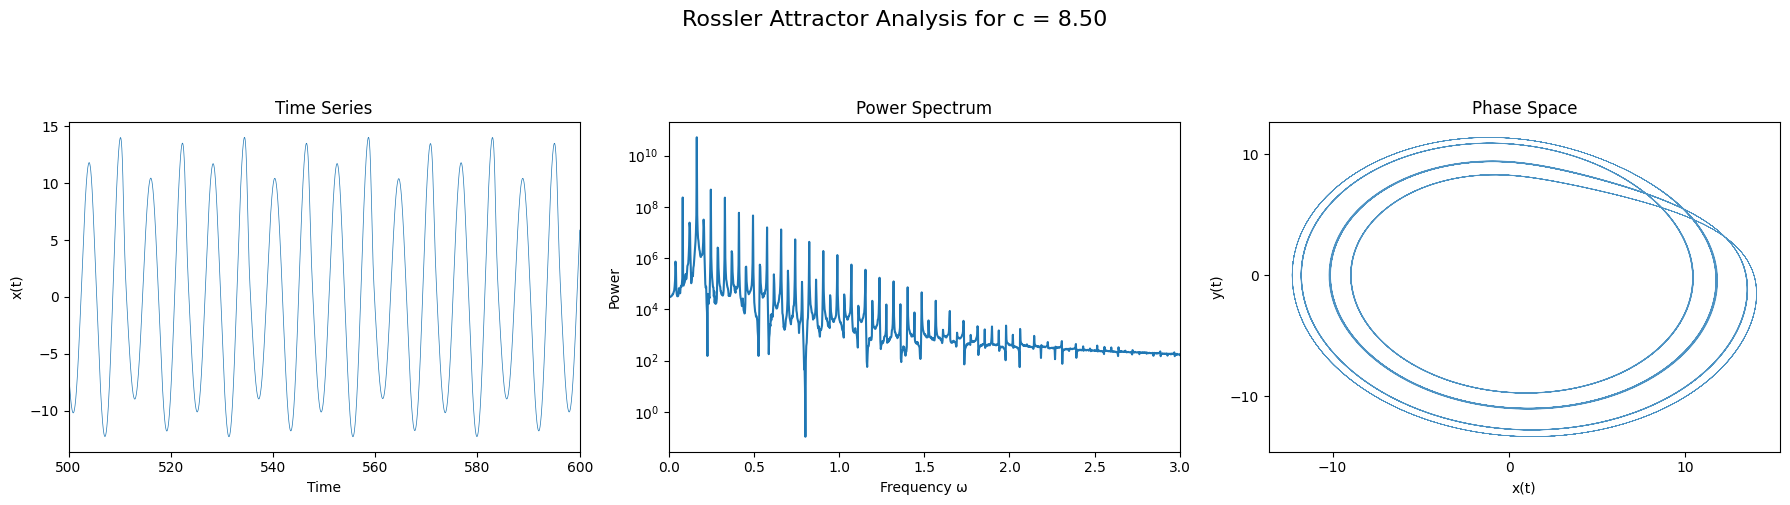

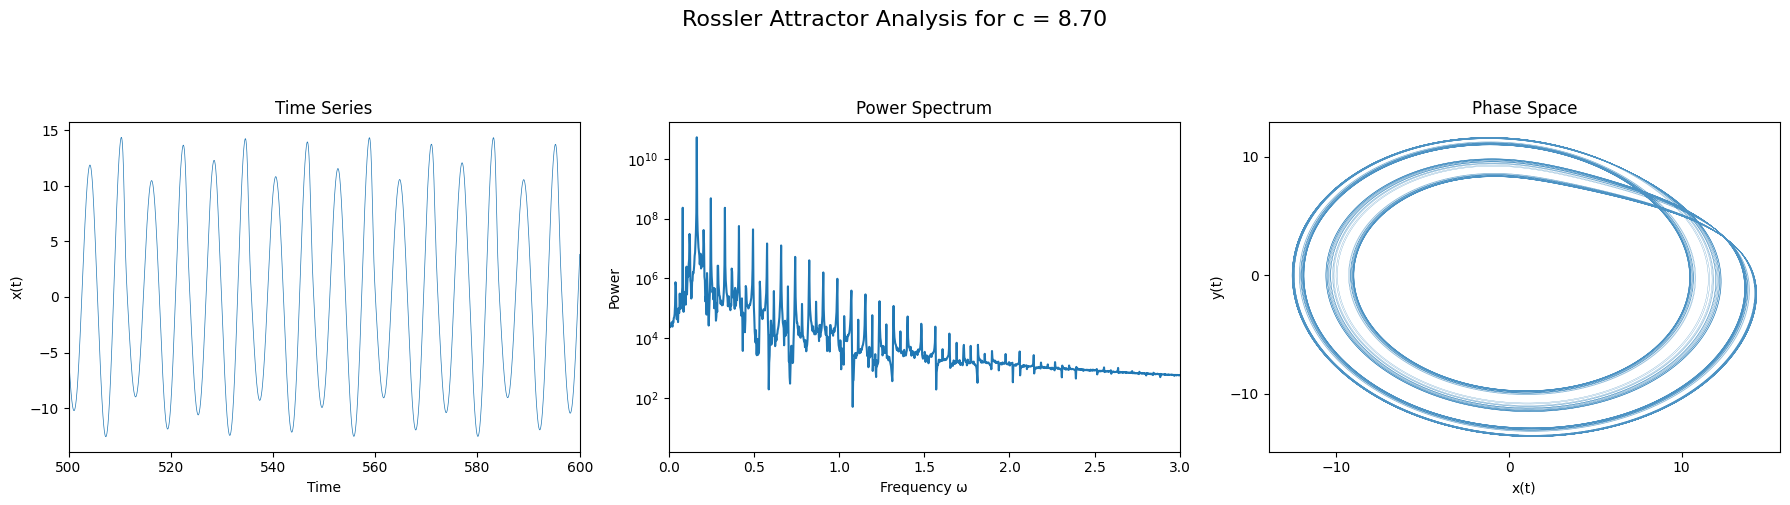

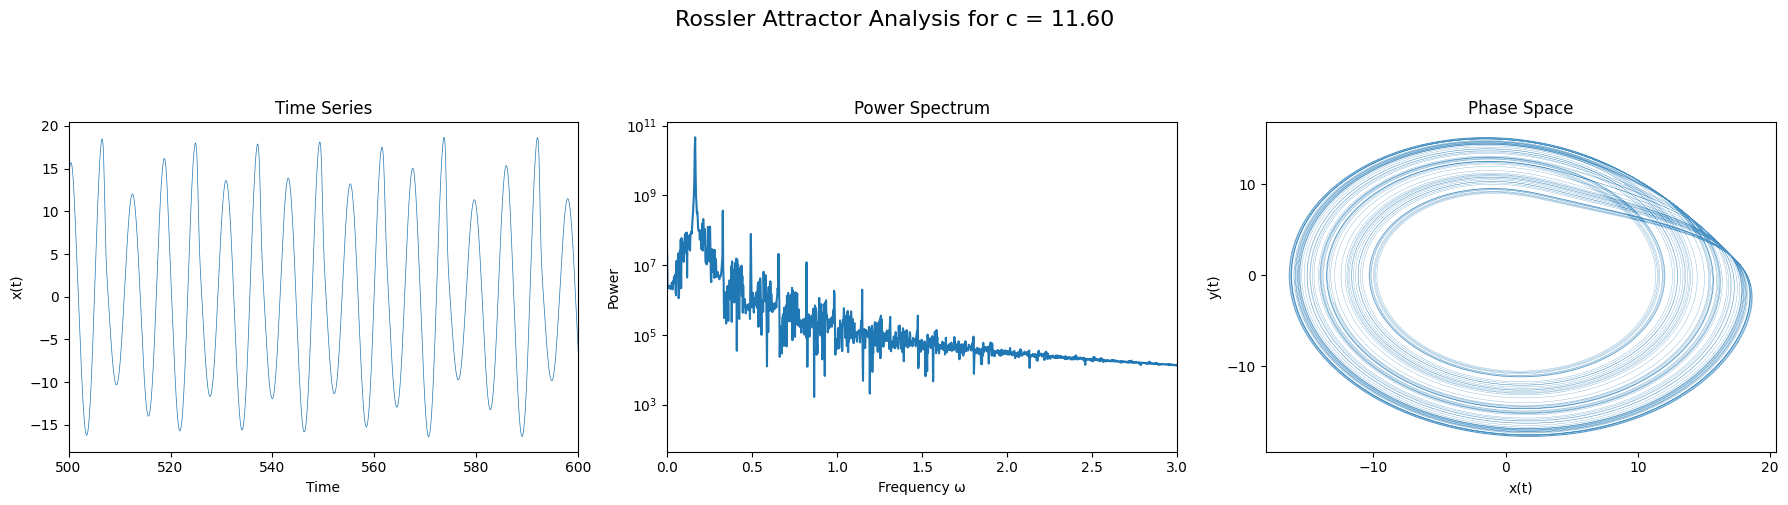

In [22]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- Define the system and helper functions ---
# (Using standard Rossler system definition)

def rossler_system(t, y, a, b, c):
    """Defines the Rossler attractor equations."""
    x, y, z = y
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

def spectrum(x, dt):
    """Calculates the power spectrum of a time series."""
    # Use Fast Fourier Transform
    # We use rfft for real-valued input
    n = len(x)
    if n == 0:
        return np.array([0]), np.array([0])
        
    P = np.abs(np.fft.rfft(x))**2
    f = np.fft.rfftfreq(n, dt)
    
    # Return only positive frequencies (rfft convention)
    return f[:n//2], P[:n//2]

# --- Set up parameters ---

# Assumed parameters for the Rossler system
a = 0.1
b = 0.1
c_values = [4, 7, 8.5, 8.7, 11.6]

# Time span and evaluation points
t_span = [0, 800]
# Increase evaluation points for smoother plots and to avoid empty data after transient removal
t_eval = np.linspace(t_span[0], t_span[1], 80000)
dt = t_eval[1] - t_eval[0]

# Index to start from to remove transient behavior
transient_index = 40000

# --- Loop, solve, and create a separate plot for each 'c' value ---

for c in c_values:
    
    # Solve the differential equation
    sol = solve_ivp(rossler_system, t_span, [1, 1, 1], t_eval=t_eval, args=(a, b, c), method='RK45')
    
    # Check if solution was successful and has enough points
    if not sol.success or len(sol.t) <= transient_index:
        print(f"Solver failed or not enough points for c = {c}")
        continue

    # Get data and remove transient
    x = sol.y[0][transient_index:]
    y = sol.y[1][transient_index:]
    t = sol.t[transient_index:]
    
    # Ensure data is not empty after slicing
    if x.size == 0:
        print(f"No data after removing transient for c = {c}")
        continue

    # Calculate power spectrum
    f, P = spectrum(x, dt)

    # --- Plotting ---
    # Create a new figure for this 'c' value with 1 row and 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    # Add a main title for this specific figure
    fig.suptitle(f'Rossler Attractor Analysis for c = {c:.2f}', fontsize=16, y=1.03)

    # Plot 1: Time series
    axs[0].plot(t, x, lw=0.5)
    axs[0].set_title('Time Series')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('x(t)')
    axs[0].set_xlim(500, 600)
    
    # Plot 2: Power spectrum
    if f.size > 0:
        axs[1].plot(f, P)
        axs[1].set_title('Power Spectrum')
        axs[1].set_xlabel('Frequency ω')
        axs[1].set_ylabel('Power')
        # Use semi-logy for better power spectrum visualization
        axs[1].set_yscale('log')
        axs[1].set_xlim(0, 3)
    
    # Plot 3: Phase space
    axs[2].plot(x, y, lw=0.2, alpha=0.8) 
    axs[2].set_title('Phase Space')
    axs[2].set_xlabel('x(t)')
    axs[2].set_ylabel('y(t)')
    # Set axis ticks to be cleaner
    axs[2].locator_params(axis='x', nbins=4)
    axs[2].locator_params(axis='y', nbins=4)


    # Use tight_layout to prevent labels from overlapping for this figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Display the plot for this 'c' value
    # In a script, each plt.show() will typically pause execution
    # In environments like Jupyter, all plots will be displayed.
    plt.show()

Starting bifurcation data generation...
  Calculating step 50/800 (c = 2.981)
  Calculating step 100/800 (c = 3.982)
  Calculating step 150/800 (c = 4.984)
  Calculating step 200/800 (c = 5.985)
  Calculating step 250/800 (c = 6.986)
  Calculating step 300/800 (c = 7.987)
  Calculating step 350/800 (c = 8.989)
  Calculating step 400/800 (c = 9.990)
  Calculating step 450/800 (c = 10.991)
  Calculating step 500/800 (c = 11.992)
  Calculating step 550/800 (c = 12.994)
  Calculating step 600/800 (c = 13.995)
  Calculating step 650/800 (c = 14.996)
  Calculating step 700/800 (c = 15.997)
  Calculating step 750/800 (c = 16.999)
  Calculating step 800/800 (c = 18.000)
Data generation complete.
Plot generated. Displaying...


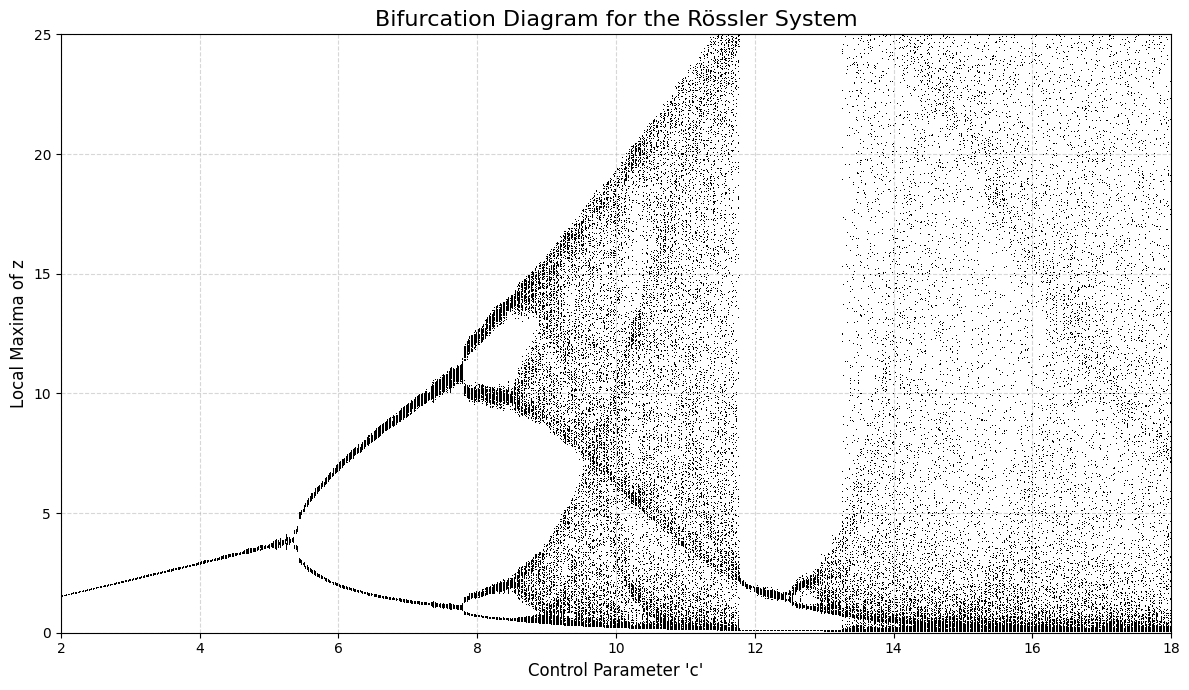

In [ ]:
#!/usr/bin/env python3

"""
This script generates and plots the bifurcation diagram for the
Rössler system of differential equations.

It demonstrates the classic period-doubling route to chaos in a
continuous-time system.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks

def rossler_system(t, state, a, b, c):

    x, y, z = state
    
    dx_dt = -y - z
    dy_dt = x + a * y
    dz_dt = b + z * (x - c)
    
    return [dx_dt, dy_dt, dz_dt]

def generate_bifurcation_data(c_values, a=0.1, b=0.1, y0=[1.0, 1.0, 1.0], 
                              t_transient=1000, t_data=1000, n_points_data=8000):
    """
    Generates the data for the bifurcation diagram.
    
    Args:
        c_values: A numpy array of the 'c' parameter values to sweep.
        a, b: Fixed parameters for the system.
        y0: Initial state [x, y, z].
        t_transient: Time to run the solver to discard transient behavior.
        t_data: Time to run the solver to collect data.
        n_points_data: Number of time points to evaluate for data collection.
        
    Returns:
        A list of tuples (c, z_peak) for plotting.
    """
    print("Starting bifurcation data generation...")
    
    # Time spans
    t_span_transient = [0, t_transient]
    t_span_data = [0, t_data]
    # Evaluation points for finding peaks accurately
    t_eval_data = np.linspace(t_span_data[0], t_span_data[1], n_points_data)
    
    bifurcation_data = []
    
    # Use the final state of the previous run as the initial state
    # for the next. This is called 'continuation'.
    current_y0 = y0

    for i, c in enumerate(c_values):
        if (i+1) % 50 == 0:
            print(f"  Calculating step {i+1}/{len(c_values)} (c = {c:.3f})")

        # 1. Run the solver to let the trajectory settle onto the attractor
        sol_transient = solve_ivp(
            rossler_system, 
            t_span_transient, 
            current_y0, 
            args=(a, b, c),
            method='RK45'
        )
        # Get the final state to use as the new initial state
        y_transient_final = sol_transient.y[:, -1]

        # 2. Run the solver again, starting from the settled state,
        #    and collect data points.
        sol_data = solve_ivp(
            rossler_system, 
            t_span_data, 
            y_transient_final, 
            args=(a, b, c),
            t_eval=t_eval_data,
            method='RK45'
        )
        
        # Extract the z-component
        z_data = sol_data.y[2]
        
        # 3. Find the local maxima (peaks) of the z-component
        #    A minimum height helps filter out numerical noise.
        min_height = 0.01
        peaks, _ = find_peaks(z_data, height=min_height)
        
        # Get the z-values at these peaks
        z_peaks = z_data[peaks]
        
        # 4. Store the data for plotting
        for peak in z_peaks:
            bifurcation_data.append((c, peak))
            
        # 5. Use the final state of this run as the y0 for the *next*
        #    transient run.
        current_y0 = sol_data.y[:, -1]

    print("Data generation complete.")
    return bifurcation_data

def plot_bifurcation_diagram(data):
    """
    Plots the bifurcation diagram using matplotlib.
    
    Args:
        data: A list of (c, z_peak) tuples.
    """
    if not data:
        print("No data to plot.")
        return

    # Unzip the data into two lists for plotting
    c_plot, z_plot = zip(*data)
    
    plt.figure(figsize=(12, 7))
    
    # Plot the data as tiny black pixels ('k,')
    # This is much more effective than scatter or line plots.
    plt.plot(c_plot, z_plot, 'k,', markersize=0.1)
    
    plt.title("Bifurcation Diagram for the Rössler System", fontsize=16)
    plt.xlabel("Control Parameter 'c'", fontsize=12)
    plt.ylabel("Local Maxima of z", fontsize=12)
    
    # Set axis limits for a good view
    plt.xlim(min(c_plot), max(c_plot))
    plt.ylim(0, 25) # z-values in this range show the structure well
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    print("Plot generated. Displaying...")
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    
    # --- Parameters ---
    
    # Fixed parameters
    A = 0.1
    B = 0.1
    
    # Sweep parameter 'c'
    C_MIN = 2.0
    C_MAX = 18.0
    N_STEPS = 800  # Number of 'c' values to simulate
    
    # Initial state
    Y0 = [1.0, 1.0, 1.0]
    
    c_sweep_values = np.linspace(C_MIN, C_MAX, N_STEPS)
    
    # 1. Generate the data
    bifurcation_data = generate_bifurcation_data(
        c_sweep_values, 
        a=A, 
        b=B, 
        y0=Y0
    )
    
    # 2. Plot the data
    plot_bifurcation_diagram(bifurcation_data)

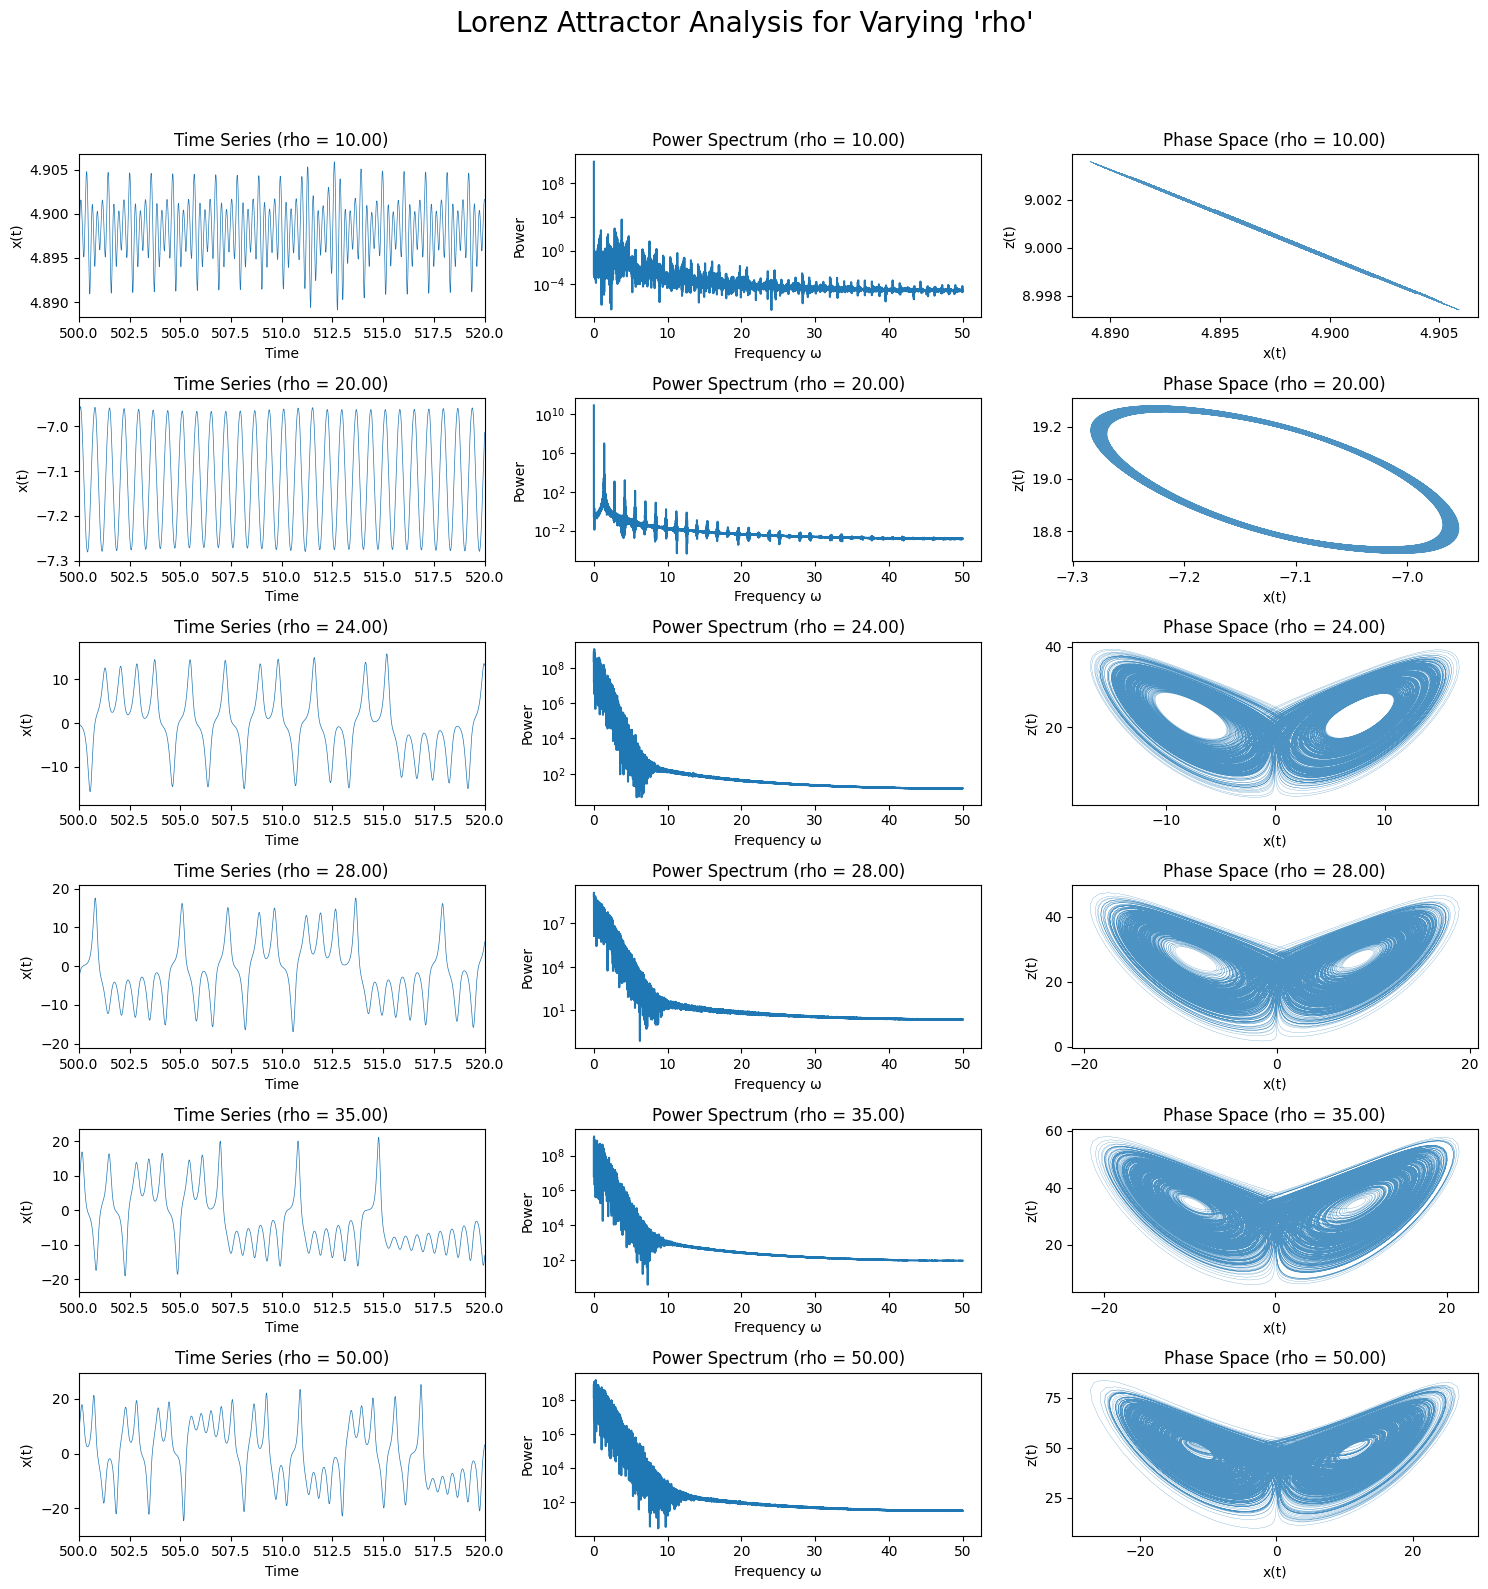

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- Define the system and helper functions ---

def lorenz_system(t, y, sigma, rho, beta):
    """Defines the Lorenz attractor equations."""
    x, y, z = y
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

def spectrum(x, dt):
    """Calculates the power spectrum of a time series."""
    # Use Fast Fourier Transform
    # We use rfft for real-valued input
    n = len(x)
    if n == 0:
        return np.array([0]), np.array([0])
        
    P = np.abs(np.fft.rfft(x))**2
    f = np.fft.rfftfreq(n, dt)
    
    # Return only positive frequencies (rfft convention)
    return f[:n//2], P[:n//2]

# --- Set up parameters ---

# Standard Lorenz parameters
sigma = 10.0
beta = 8.0 / 3.0
# Create an array of 6 different 'rho' values to plot
# This range shows the transition from stable points to chaos
rho_values = [10, 20, 24, 28, 35, 50]

# Time span and evaluation points (kept same as user's Rössler script)
t_span = [0, 800]
# Increase evaluation points for smoother plots and to avoid empty data after transient removal
t_eval = np.linspace(t_span[0], t_span[1], 80000)
dt = t_eval[1] - t_eval[0]

# Index to start from to remove transient behavior (kept same as user's Rössler script)
transient_index = 40000

# --- Create the plot ---

fig, axs = plt.subplots(6, 3, figsize=(15, 16))

# Adjust spacing
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Loop over the 6 'rho' values
for i, rho in enumerate(rho_values):
    
    # Solve the differential equation
    # Note: args are now (sigma, rho, beta)
    sol = solve_ivp(lorenz_system, t_span, [1, 1, 1], t_eval=t_eval, args=(sigma, rho, beta), method='RK45')
    
    # Check if solution was successful and has enough points
    if not sol.success or len(sol.t) <= transient_index:
        print(f"Solver failed or not enough points for rho = {rho}")
        continue

    # Get data and remove transient
    x = sol.y[0][transient_index:]
    y = sol.y[1][transient_index:]
    z = sol.y[2][transient_index:] # Get z-component for phase space plot
    t = sol.t[transient_index:]
    
    # Ensure data is not empty after slicing
    if x.size == 0:
        print(f"No data after removing transient for rho = {rho}")
        continue

    # Calculate power spectrum (based on x component)
    f, P = spectrum(x, dt)

    # --- Plotting ---
    
    # Time series (x vs t)
    axs[i,0].plot(t, x, lw=0.5)
    axs[i,0].set_title(f'Time Series (rho = {rho:.2f})')
    axs[i,0].set_xlabel('Time')
    axs[i,0].set_ylabel('x(t)')
    axs[i,0].set_xlim(500, 520) # Keep user's original xlim
    
    # Power spectrum
    if f.size > 0:
        axs[i,1].plot(f, P)
        axs[i,1].set_title(f'Power Spectrum (rho = {rho:.2f})')
        axs[i,1].set_xlabel('Frequency ω')
        axs[i,1].set_ylabel('Power')
        # Use semi-logy for better power spectrum visualization
        axs[i,1].set_yscale('log')
        # axs[i,1].set_xlim(1,2) # Keep user's original xlim
    
    # Phase space (Plotting x vs z for the classic "butterfly")
    axs[i,2].plot(x, z, lw=0.2, alpha=0.8) 
    axs[i,2].set_title(f'Phase Space (rho = {rho:.2f})')
    axs[i,2].set_xlabel('x(t)')
    axs[i,2].set_ylabel('z(t)') # Changed to z(t)
    # Set axis ticks to be cleaner
    axs[i,2].locator_params(axis='x', nbins=4)
    axs[i,2].locator_params(axis='y', nbins=4)


# Add a main title for the whole figure
fig.suptitle('Lorenz Attractor Analysis for Varying \'rho\'', fontsize=20, y=1.02)

# Use tight_layout to prevent labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# Display the plot
plt.show()

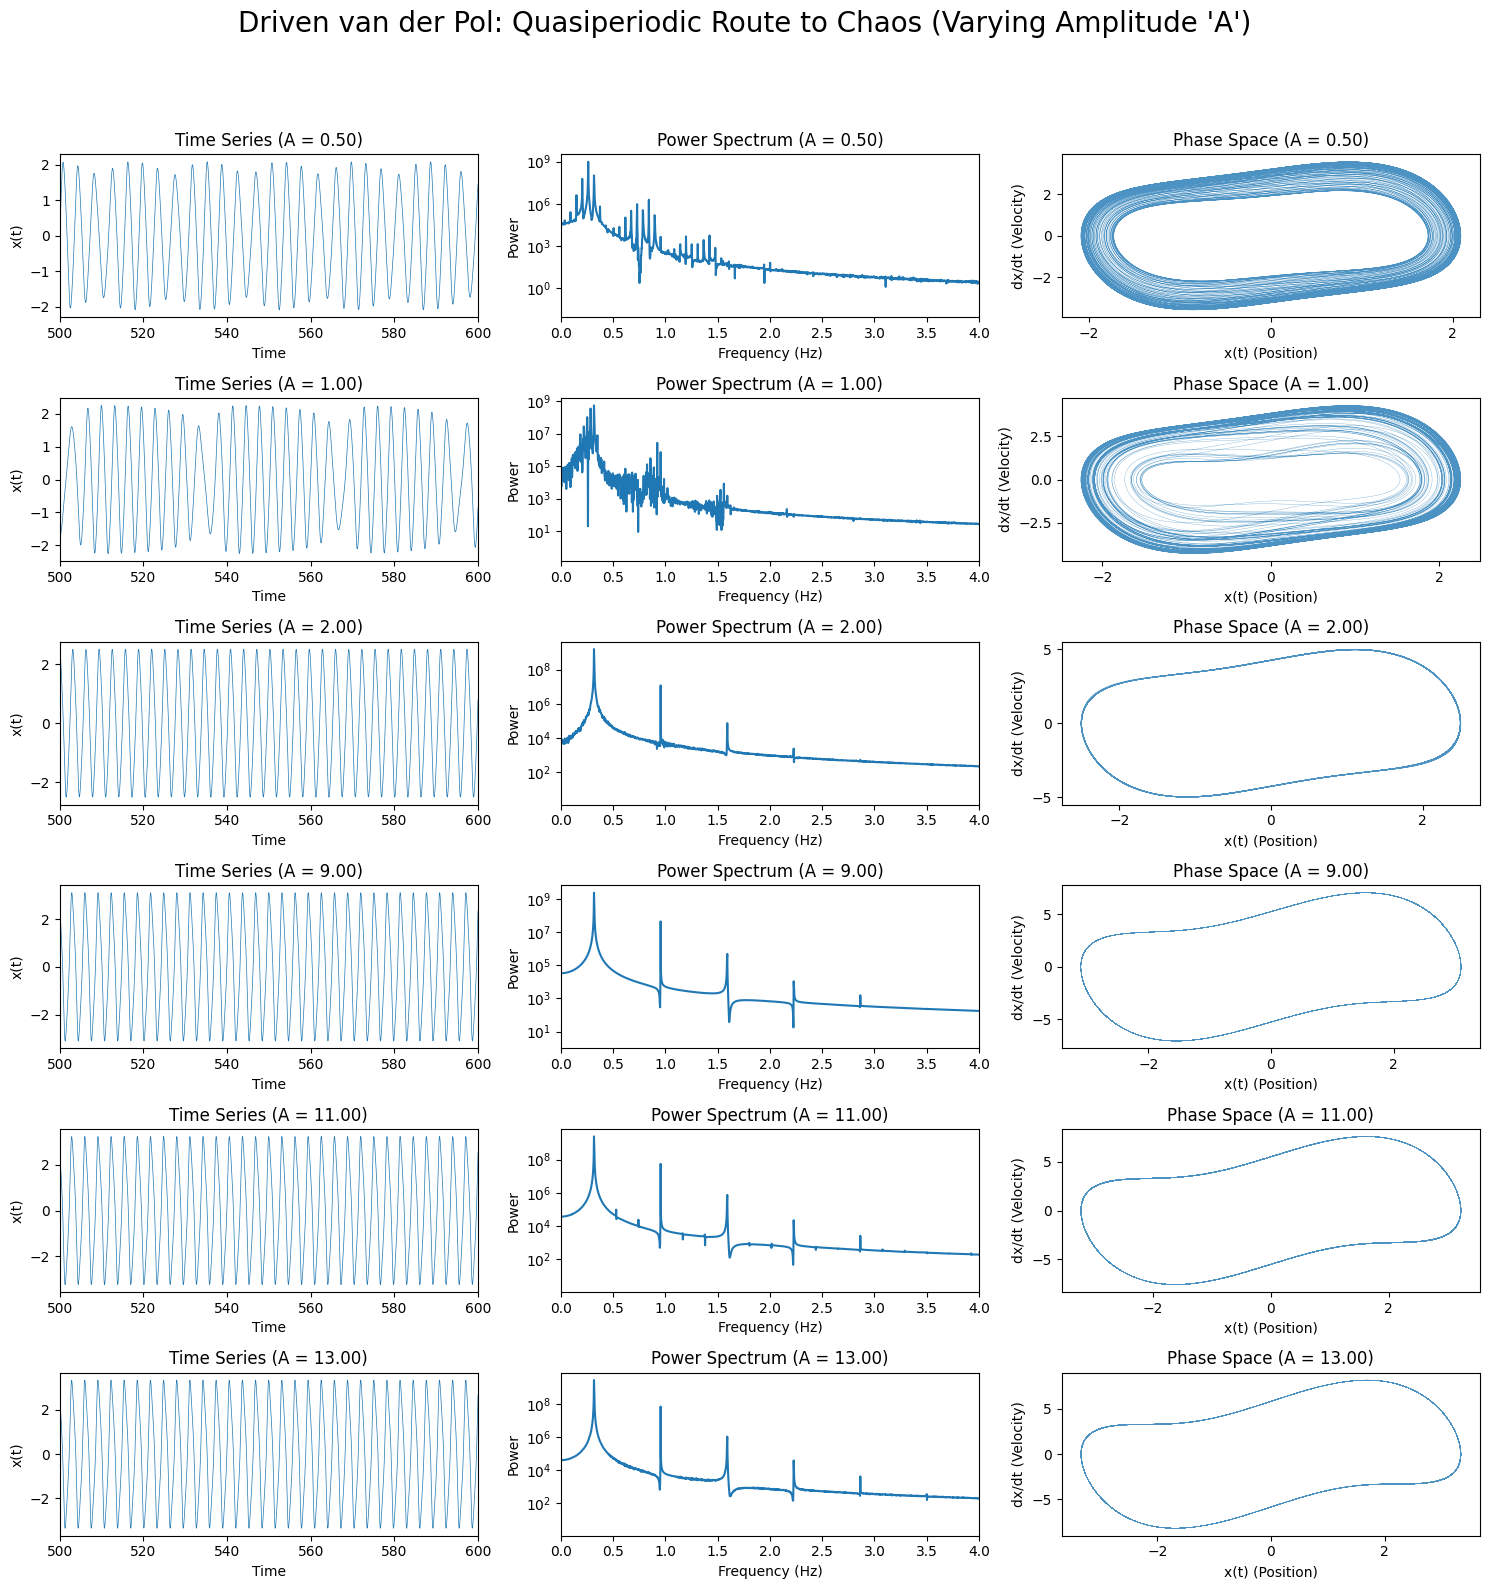

In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- Define the system and helper functions ---

def driven_vdp_system(t, y, mu, A, omega):
    """
    Defines the driven van der Pol oscillator equations.
    Equation: d²x/dt² - mu(1 - x²)dx/dt + x = A cos(omega*t)
    System:
    dx/dt = y
    dy/dt = mu(1 - x²)y - x + A cos(omega*t)
    """
    x, y_vdp = y  # y_vdp is dx/dt
    dxdt = y_vdp
    dydt = mu * (1 - x**2) * y_vdp - x**3 + A * np.cos(omega * t)
    return [dxdt, dydt]

def spectrum(x, dt):
    """Calculates the power spectrum of a time series."""
    # Use Fast Fourier Transform
    # We use rfft for real-valued input
    n = len(x)
    if n == 0:
        return np.array([0]), np.array([0])
        
    P = np.abs(np.fft.rfft(x))**2
    f = np.fft.rfftfreq(n, dt)
    
    # Return only positive frequencies (rfft convention)
    return f[:n//2], P[:n//2]

# --- Set up parameters ---

# van der Pol parameters
mu = 0.5     # Non-linearity coefficient
omega = 2   # Driving (angular) frequency
# We will vary the driving amplitude 'A'
# This range is chosen to show the transition from periodic to quasiperiodic to chaos
A_values = [0.5, 1.0, 2.0, 9.0, 11.0, 13.0]

# Time span and evaluation points
t_span = [0, 800]
# Increase evaluation points for smoother plots and to avoid empty data after transient removal
t_eval = np.linspace(t_span[0], t_span[1], 80000)
dt = t_eval[1] - t_eval[0]

# Index to start from to remove transient behavior
transient_index = 40000

# --- Create the plot ---

fig, axs = plt.subplots(6, 3, figsize=(15, 16))

# Adjust spacing
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Loop over the 6 'A' (Amplitude) values
for i, A in enumerate(A_values):
    
    # Solve the differential equation
    # Initial state is 2D: [x, y]
    sol = solve_ivp(driven_vdp_system, t_span, [0,0], t_eval=t_eval, args=(mu, A, omega), method='RK45')
    
    # Check if solution was successful and has enough points
    if not sol.success or len(sol.t) <= transient_index:
        print(f"Solver failed or not enough points for A = {A}")
        continue

    # Get data and remove transient
    x = sol.y[0][transient_index:]
    y = sol.y[1][transient_index:] # This is dx/dt
    t = sol.t[transient_index:]
    
    # Ensure data is not empty after slicing
    if x.size == 0:
        print(f"No data after removing transient for A = {A}")
        continue

    # Calculate power spectrum (based on x component)
    f, P = spectrum(x, dt)

    # --- Plotting ---
    
    # Time series (x vs t)
    axs[i,0].plot(t, x, lw=0.5)
    axs[i,0].set_title(f'Time Series (A = {A:.2f})')
    axs[i,0].set_xlabel('Time')
    axs[i,0].set_ylabel('x(t)')
    axs[i,0].set_xlim(500, 600) # Keep user's original xlim
    
    # Power spectrum
    # This is the key plot for the quasiperiodic route!
    if f.size > 0:
        axs[i,1].plot(f, P)
        axs[i,1].set_title(f'Power Spectrum (A = {A:.2f})')
        axs[i,1].set_xlabel('Frequency (Hz)')
        axs[i,1].set_ylabel('Power')
        axs[i,1].set_yscale('log')
        # f_drive = omega / (2*pi) approx 0.38 Hz
        # f_nat is also in this range
        axs[i,1].set_xlim(0, 4.0) # Zoom in on the relevant frequencies
    
    # Phase space (Plotting x vs dx/dt)
    # A simple loop = periodic
    # A filled torus = quasiperiodic
    # A "mess" = chaotic
    axs[i,2].plot(x, y, lw=0.2, alpha=0.8) 
    axs[i,2].set_title(f'Phase Space (A = {A:.2f})')
    axs[i,2].set_xlabel('x(t) (Position)')
    axs[i,2].set_ylabel('dx/dt (Velocity)')
    # Set axis ticks to be cleaner
    axs[i,2].locator_params(axis='x', nbins=4)
    axs[i,2].locator_params(axis='y', nbins=4)


# Add a main title for the whole figure
fig.suptitle("Driven van der Pol: Quasiperiodic Route to Chaos (Varying Amplitude 'A')", fontsize=20, y=1.02)

# Use tight_layout to prevent labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# Display the plot
plt.show()

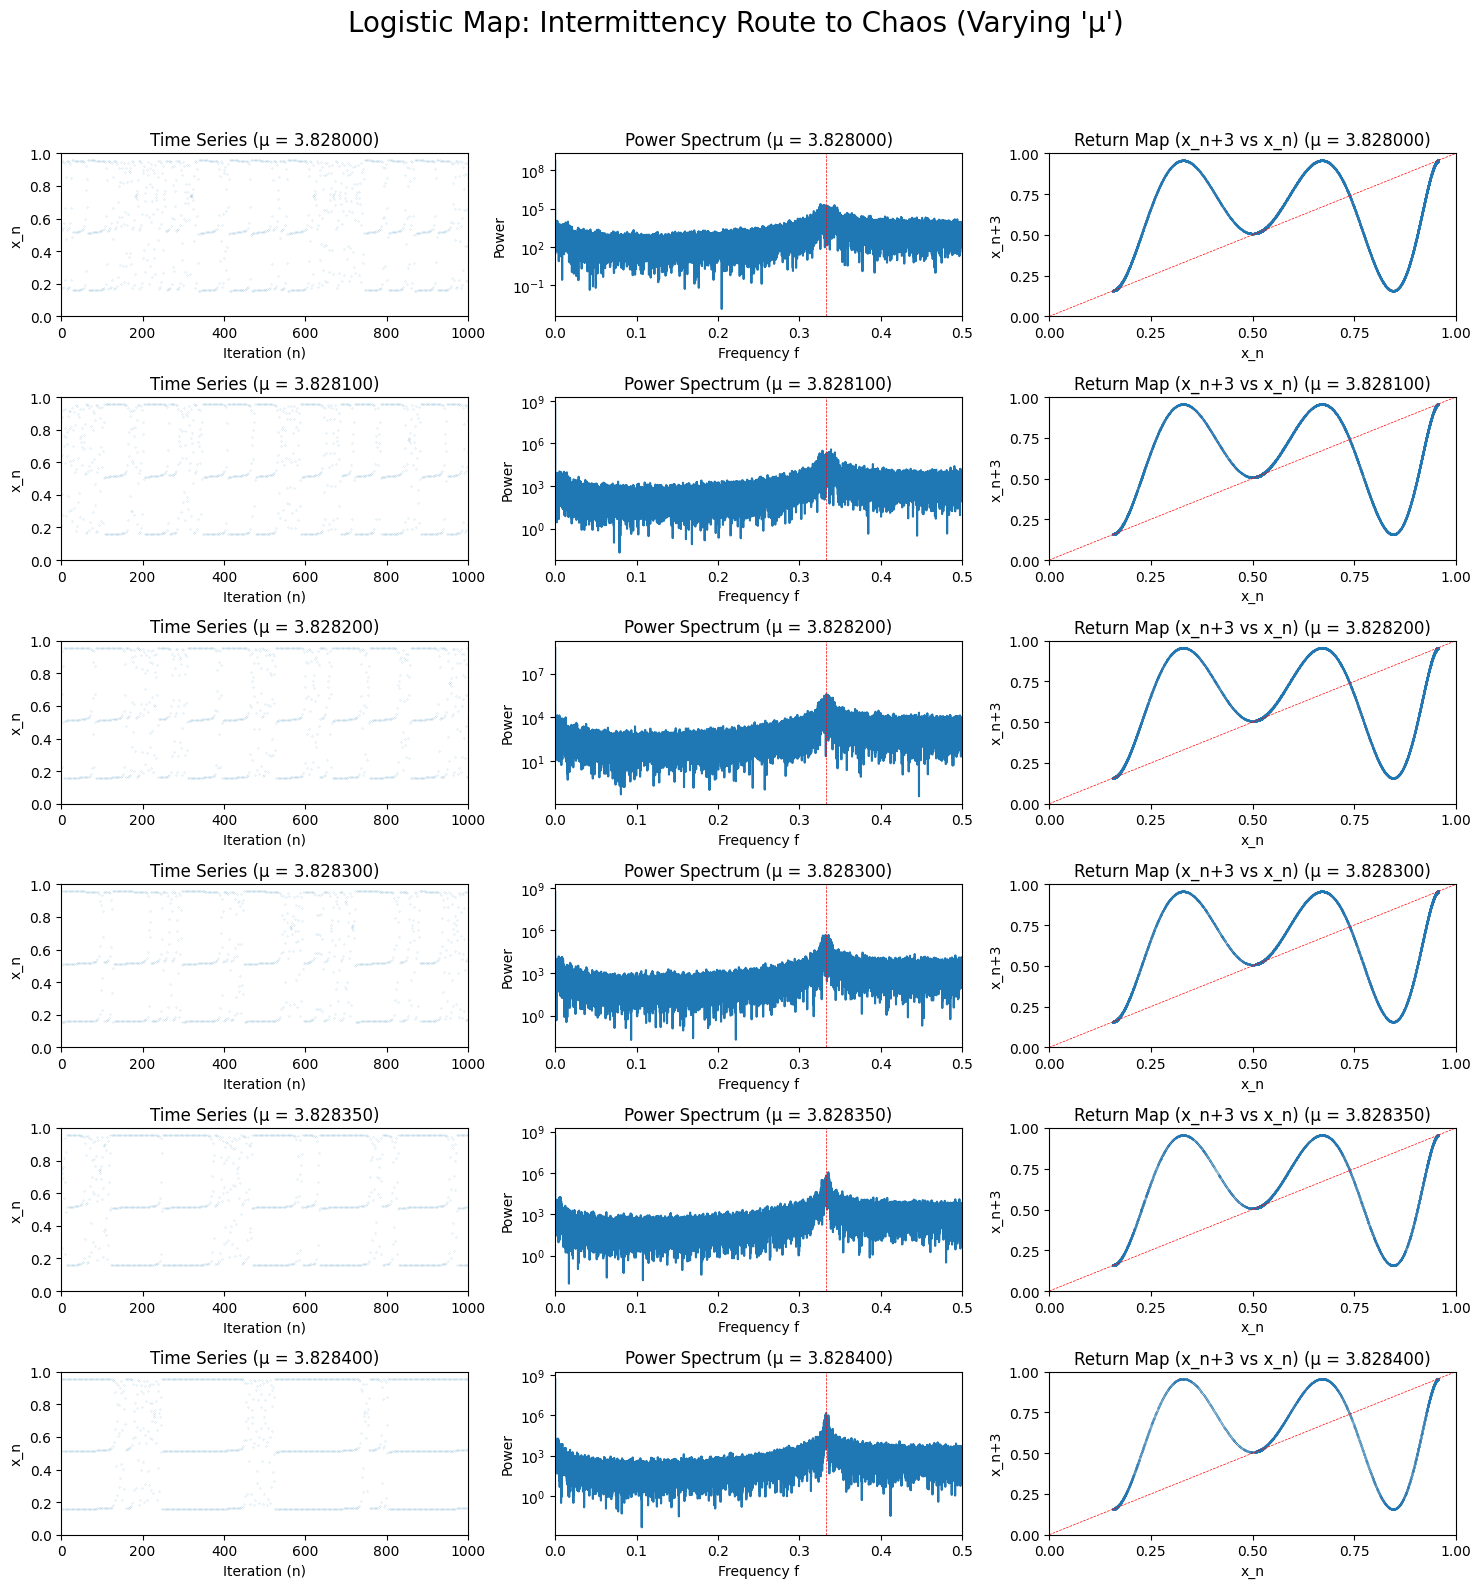

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --- Define the system and helper functions ---

def logistic_map(x, mu):
    """Calculates the next iteration of the logistic map."""
    return mu * x * (1.0 - x)

def spectrum(x, dt):
    """Calculates the power spectrum of a time series."""
    # Use Fast Fourier Transform
    # We use rfft for real-valued input
    n = len(x)
    if n == 0:
        return np.array([0]), np.array([0])
        
    P = np.abs(np.fft.rfft(x))**2
    f = np.fft.rfftfreq(n, dt)
    
    # Return only positive frequencies (rfft convention)
    return f[:n//2], P[:n//2]

def generate_logistic_series(x0, mu, n_transient, n_eval):
    """Generates a time series for the logistic map."""
    n_total = n_transient + n_eval
    x = np.zeros(n_total)
    x[0] = x0
    
    for i in range(n_total - 1):
        x[i+1] = logistic_map(x[i], mu)
        
    # Return the series after the transient
    return x[n_transient:]

# --- Set up parameters ---

# We will vary the parameter 'mu' in the logistic map
# We are looking for Type-I intermittency just before the period-3 window
# The tangent bifurcation for the period-3 window is at mu_c ≈ 3.828427...
# We will choose values just below this to show the intermittent behavior.
mu_values = [3.828, 3.8281, 3.8282, 3.8283, 3.82835, 3.8284]

# Number of iterations
n_transient = 40000  # Number of iterations to discard
n_eval = 40000       # Number of iterations to analyze

# Initial condition
x0 = 0.5
# Time step for spectrum (each iteration is one step)
dt = 1.0 

# --- Create the plot ---

fig, axs = plt.subplots(6, 3, figsize=(15, 16))

# Adjust spacing
plt.subplots_adjust(hspace=0.6, wspace=0.3)

# Loop over the 6 'mu' values
for i, mu in enumerate(mu_values):
    
    # Generate the time series
    x = generate_logistic_series(x0, mu, n_transient, n_eval)
    t = np.arange(n_eval) # Iteration number 'n'
    
    # Calculate power spectrum
    f, P = spectrum(x, dt)

    # --- Plotting ---
    
    # Time series (x_n vs n)
    # This plot will show the "laminar" (almost periodic) phases
    # and the chaotic "bursts"
    axs[i,0].plot(t, x, 'o', markersize=0.1, alpha=0.8) # Use small markers for discrete map
    axs[i,0].set_title(f'Time Series (μ = {mu:.6f})')
    axs[i,0].set_xlabel('Iteration (n)')
    axs[i,0].set_ylabel('x_n')
    # Zoom in on a shorter time window to see the bursts
    axs[i,0].set_xlim(0, 1000) 
    axs[i,0].set_ylim(0, 1)
    
    # Power spectrum
    if f.size > 0:
        axs[i,1].plot(f, P)
        axs[i,1].set_title(f'Power Spectrum (μ = {mu:.6f})')
        axs[i,1].set_xlabel('Frequency f')
        axs[i,1].set_ylabel('Power')
        axs[i,1].set_yscale('log')
        # Frequency is from 0 to 0.5 (Nyquist freq)
        axs[i,1].set_xlim(0, 0.5) 
        # The 1/3 peak (from period-3) will be prominent
        axs[i,1].axvline(1/3, color='r', linestyle='--', lw=0.5, label='f=1/3')
    
    # Third-Iterate Return Map (x_{n+3} vs x_n)
    # This is the key plot for Type-I intermittency
    # It shows the "bottleneck" at the tangent bifurcation
    x_n = x[:-3]
    x_n_plus_3 = x[3:]
    axs[i,2].plot(x_n, x_n_plus_3, 'o', markersize=0.1, alpha=0.5) 
    # Plot the y=x line for reference
    axs[i,2].plot([0, 1], [0, 1], 'r--', lw=0.5)
    axs[i,2].set_title(f'Return Map (x_n+3 vs x_n) (μ = {mu:.6f})')
    axs[i,2].set_xlabel('x_n')
    axs[i,2].set_ylabel('x_n+3')
    axs[i,2].set_xlim(0, 1)
    axs[i,2].set_ylim(0, 1)
    # Set axis ticks to be cleaner
    axs[i,2].locator_params(axis='x', nbins=4)
    axs[i,2].locator_params(axis='y', nbins=4)


# Add a main title for the whole figure
fig.suptitle("Logistic Map: Intermittency Route to Chaos (Varying 'μ')", fontsize=20, y=1.02)

# Use tight_layout to prevent labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# Display the plot
plt.show()

In [ ]:
#fft
def fft(x):
    n=len(x)
    if n==1:
        return x
    
 
    even = fft(x[0::2])
    odd = fft(x[1::2])

    out=[0]*n
    omega = np.exp(1j*2*np.pi/n)
    for i in range(n//2):
        out[i] = even[i] + omega**(i) * odd[i]
        out[i + n // 2] = even[i] - omega**(i) * odd[i]

    return out

